In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay,
    precision_recall_curve, f1_score
)
from xgboost import XGBClassifier


In [31]:
train_df = pd.read_csv('../data/fraudTrain.csv')
test_df = pd.read_csv('../data/fraudTest.csv')

In [32]:
def map_time_of_day(hour):
    if 0 <= hour < 5:
        return 'Midnight'
    elif 5 <= hour < 8:
        return 'Early Morning'
    elif 8 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 14:
        return 'Noon'
    elif 14 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 20:
        return 'Evening'
    else:
        return 'Night'


In [33]:
def preprocess(df):
    df = df.copy()
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['dob'] = pd.to_datetime(df['dob'])

    df['age'] = ((df['trans_date_trans_time'] - df['dob']).dt.days / 365.25).astype(int)
    df['hour'] = df['trans_date_trans_time'].dt.hour
    df['time_group'] = df['hour'].apply(map_time_of_day)

    def haversine(lat1, lon1, lat2, lon2):
        R = 6371
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
        return R * c

    df['distance_km'] = haversine(df['lat'], df['long'], df['merch_lat'], df['merch_long'])

    return df


In [34]:
train_df = preprocess(train_df)
test_df = preprocess(test_df)


In [35]:
features = ['merchant', 'amt', 'distance_km', 'category', 'age', 'time_group']
TARGET = 'is_fraud'

X_train = train_df[features].copy()
y_train = train_df[TARGET].copy()
X_test = test_df[features].copy()
y_test = test_df[TARGET].copy()


In [36]:
encoders = {}
for col in ['merchant', 'category', 'time_group']:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])
    encoders[col] = le


In [37]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [38]:
from sklearn import set_config
set_config(display='text') 

In [39]:
xgb_model = XGBClassifier(
    n_estimators=1000,
    max_depth=12,
    learning_rate=0.001,
    use_label_encoder=False,
    eval_metric='logloss',
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=25,
    n_jobs=-1,
    random_state=42
)
xgb_model.fit(X_train_scaled, y_train)


/Users/harryphoebus/miniconda3/envs/ML/lib/python3.11/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.001, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=12,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=-1,
              num_parallel_tree=None, predictor=None, random_state=42, ...)


🔍 Model: XGBoost Model
               precision    recall  f1-score   support

Not Fraud (0)       1.00      1.00      1.00    553574
    Fraud (1)       0.70      0.79      0.74      2145

     accuracy                           1.00    555719
    macro avg       0.85      0.90      0.87    555719
 weighted avg       1.00      1.00      1.00    555719

AUC-ROC Score: 0.9913


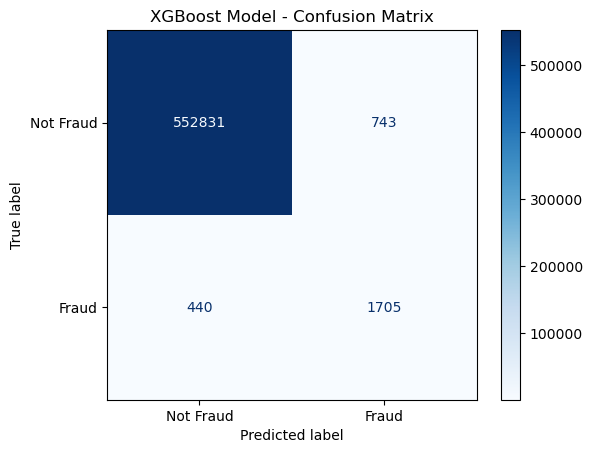

In [40]:
def evaluate_model(name, model, X, y):
    print(f"\n🔍 Model: {name}")
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]
    
    print(classification_report(y, y_pred, target_names=['Not Fraud (0)', 'Fraud (1)']))
    print(f"AUC-ROC Score: {roc_auc_score(y, y_proba):.4f}")
    
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

evaluate_model("XGBoost Model", xgb_model, X_test_scaled, y_test)


In [41]:
y_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]
prec, rec, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (prec * rec) / (prec + rec)
best_idx = np.argmax(f1_scores)

print(f"📌 Best Threshold: {thresholds[best_idx]:.3f}")
print(f"✅ Best F1 Score: {f1_scores[best_idx]:.3f}")


📌 Best Threshold: 0.579
✅ Best F1 Score: 0.762


In [42]:
y_pred_custom = (y_proba >= 0.625).astype(int)
print(classification_report(y_test, y_pred_custom, target_names=["Not Fraud", "Fraud"]))


              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    553574
       Fraud       0.85      0.65      0.74      2145

    accuracy                           1.00    555719
   macro avg       0.92      0.83      0.87    555719
weighted avg       1.00      1.00      1.00    555719



In [43]:
os.makedirs("../model_saved", exist_ok=True)
joblib.dump(xgb_model, "../model_saved/xgb_model.joblib")
joblib.dump(scaler, "../model_saved/scaler.joblib")
joblib.dump(encoders, "../model_saved/encoders.joblib")

print("✅ Model and preprocessing tools saved successfully.")


✅ Model and preprocessing tools saved successfully.


In [44]:
# Load saved model/tools
xgb_model = joblib.load("../model_saved/xgb_model.joblib")
scaler = joblib.load("../model_saved/scaler.joblib")
encoders = joblib.load("../model_saved/encoders.joblib")

# New sample input
new_data = pd.DataFrame([{
    'merchant': 'fraud_Kirlin and Sons',
    'amt': 10000.0,
    'distance_km': 5,
    'category': 'misc_net',
    'age': 50,
    'time_group': 'Evening'
}])

# Encode categorical features
for col in ['merchant', 'category', 'time_group']:
    new_data[col] = encoders[col].transform(new_data[col])

# Scale numerical features
X_new = scaler.transform(new_data)

# Predict fraud probability
proba = xgb_model.predict_proba(X_new)[0][1]
print(f"🚨 Fraud Probability: {proba:.4f}")


🚨 Fraud Probability: 0.2575
